In [94]:
import sys
sys.path.insert(0, 'utils')
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import ds_charts as ds
from ds_charts import plot_evaluation_results
import itertools as it
import timeit
import os



%matplotlib inline

In [95]:

dataset = 'covid/Africa'
suffix = 'covid_dankfe3'
file_name = ''

data_dir = f'data/{dataset}/'
image_dir = f'images/{dataset}/{suffix}/'

if not os.path.exists(data_dir):
        os.mkdir(data_dir)
if not os.path.exists(image_dir):
        os.mkdir(image_dir)

train_test_avaliable = True

if train_test_avaliable:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}_train.csv',parse_dates=['current_date'], infer_datetime_format=True)
        test = pd.read_csv(f'{data_dir}{file_name}{suffix}_test.csv',parse_dates=['current_date'], infer_datetime_format=True)
else:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}.csv',parse_dates=['current_date'], infer_datetime_format=True)

In [97]:
# Tratamento de missing values

le = LabelEncoder()

# train = train.drop(columns=['ratio'])
# train = train.dropna(subset=['high_risk_2w'])
# train = train.dropna(subset=['renewable_percentage'])

variable_types = ds.get_variable_types(train)
print(variable_types)

train = train.drop(columns=variable_types['Date'])
train['country'] = le.fit_transform(train['country'])
train['first_date'] = le.fit_transform(train['first_date'])
#train['city'] = le.fit_transform(train['city'])
# train['weapon'] = le.fit_transform(train['weapon'])
# train['district'] = le.fit_transform(train['district'])
# train['neighborhood'] = le.fit_transform(train['neighborhood'])
# train['description'] = le.fit_transform(train['description'])
#train = train.dropna(subset=['last_year_temp'])
#train = train.dropna(subset=['one_year_diff'])
print(train.isna().sum()[train.isna().sum() != 0])
print(train.iloc[0])

if train_test_avaliable:
    test = test.drop(columns=variable_types['Date'])
    test['country'] = le.fit_transform(test['country'])
    test['first_date'] = le.fit_transform(test['first_date'])
    #test['city'] = le.fit_transform(test['city'])
    # test['weapon'] = le.fit_transform(test['weapon'])
    # test['district'] = le.fit_transform(test['district'])
    # test['description'] = le.fit_transform(test['description'])
    # train['neighborhood'] = le.fit_transform(train['neighborhood'])
    # test['neighborhood'] = le.fit_transform(test['neighborhood'])
    #test = test.dropna(subset=['last_year_temp'])
    #test = test.dropna(subset=['one_year_diff'])
    print(test.isna().sum()[test.isna().sum() != 0])



{'Numeric': ['cases', 'deaths', 'population', 'nr_months', 'ratio', 'cases_100k', 'avg_2weeks', 'avg_2w_100k', 'sum_2weeks', 'sum_2w_100k', 'current_date_day', 'current_date_month', 'current_date_season', 'current_date_weekday', 'cases_mean_per_country', 'cases_std_per_country', 'cases_median_per_country', 'cases_max_per_country', 'cases_min_per_country', 'deaths_mean_per_country', 'deaths_std_per_country', 'deaths_median_per_country', 'deaths_max_per_country', 'deaths_min_per_country', 'current_risk'], 'Binary': ['high_risk_2w', 'current_date_year'], 'Date': [], 'Symbolic': ['country', 'first_date']}
Series([], dtype: int64)
cases                        4.615598
deaths                        2.12679
population                   0.291554
nr_months                    1.273842
ratio                        1.308411
cases_100k                   2.620946
avg_2weeks                   3.457762
avg_2w_100k                  2.659086
sum_2weeks                   3.457776
sum_2w_100k             

In [98]:
target = 'high_risk_2w'
positive = True
negative = False

if train_test_avaliable:
    trnY: np.ndarray = train.pop(target).values
    trnX: np.ndarray = train.values
    tstY: np.ndarray = test.pop(target).values
    tstX: np.ndarray = test.values
    labels: np.ndarray = pd.unique(trnY)
else:
    y = train.pop(target).values
    X = train.values
    labels: np.ndarray = pd.unique(y)

model_scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}

In [99]:
# TEST CONFIGURATIONS
train_config = {
    'KNN' : True,
    'DT' : True,
    'RF' : True,
    'GB' : True,
    'iterations' : 10,
}

times = {
    'NB' : {'fit': [], 'pred': []},
    'KNN' : {'fit': [], 'pred': [], 'param': []},
    'DT' : {'fit': [], 'pred': [], 'param': []},
    'RF' : {'fit': [], 'pred': [], 'param': []},
    'GB' : {'fit': [], 'pred': [], 'param': []},
}

model_importances = {
    'DT' : [],
    'RF' : [],
    'GB' : [],
}

In [100]:
def get_scores_fold(y_train,y_prediction,store,model):
    store[model]['precision'].append(metrics.precision_score(y_train,y_prediction))
    store[model]['recall'].append(metrics.recall_score(y_train,y_prediction))
    store[model]['accuracy'].append(metrics.accuracy_score(y_train,y_prediction))
    store[model]['auc'].append(metrics.roc_auc_score(y_train,y_prediction))
    store[model]['F1'].append(metrics.f1_score(y_train,y_prediction))
    return store

In [101]:
def get_best_params(model,params, X, y,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            print(i, end= ' ')
            trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        # print(f"Parameter time: {timeit.default_timer() - start_time}")
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

def get_best_params_train_test(model,params, trnX, trnY, tstX, tstY ,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            # print(i, end= ' ')
            # trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

0 zfit time: 0.044739799999661045
zpredict: 0.013315299998794217
1 zfit time: 0.05258730000059586


zpredict: 0.006067999998776941
2 zfit time: 0.13971519999904558
zpredict: 0.006575800000064191
3 zfit time: 0.2563561999995727
zpredict: 0.004549899998892215
4 zfit time: 0.07991530000072089
zpredict: 0.007148300001063035
5 zfit time: 0.06623450000006414
zpredict: 0.010419399999591406
6 zfit time: 0.039175200001409394
zpredict: 0.009147700000539771
7 zfit time: 0.1411699000000226
zpredict: 0.006711899999572779
8 zfit time: 0.14365550000002258
zpredict: 0.008122699999148608
9 zfit time: 0.197537399999419
zpredict: 0.00641650000034133


<Figure size 600x450 with 0 Axes>

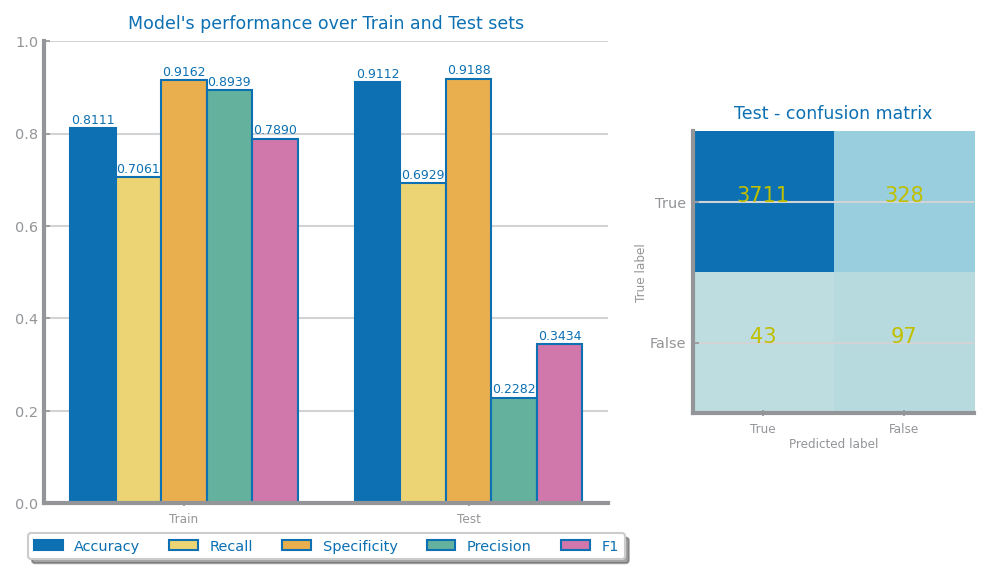

In [102]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

iterations = train_config['iterations']

fit_time = []
pred_time = []
nb_train_predictions = []
nb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_nb = BernoulliNB()
counter = 0
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
    start_time = timeit.default_timer()
    clf_nb.fit(trnX, trnY)
    times['NB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_nb.predict(trnX)
    # print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_nb.predict(tstX)
    times['NB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    nb_train_predictions.append(prd_trn)
    nb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'NB')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}NB.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.005699600000298233
train_predict time: 3.713600099999894
zpredict: 0.8898124000006646
1 zfit time: 0.0020230999998602783
train_predict time: 3.653269699998418
zpredict: 0.9804885000012291
2 zfit time: 0.002110599998559337
train_predict time: 3.758811499999865
zpredict: 0.9743833000011364
3 zfit time: 0.0021517999994102865
train_predict time: 3.7069353999995656
zpredict: 0.8728943999994954
4 zfit time: 0.0026890999997704057
train_predict time: 3.508200600001146
zpredict: 0.8900732000001881
5 zfit time: 0.0020617999998648884
train_predict time: 3.551890100001401
zpredict: 0.9629307999985031
6 zfit time: 0.001958699998795055
train_predict time: 3.7453710999998293
zpredict: 0.8972181999997701
7 zfit time: 0.0019737999991775723
train_predict time: 3.5743684000008216
zpredict: 0.9480624000007083
8 zfit time: 0.002592299999378156
train_predict time: 3.6395009999996546
zpredict: 0.8624709999985498
9 zfit time: 0.0021097999997437
train_predict time: 3.924441700000898
zpredict: 0.

<Figure size 600x450 with 0 Axes>

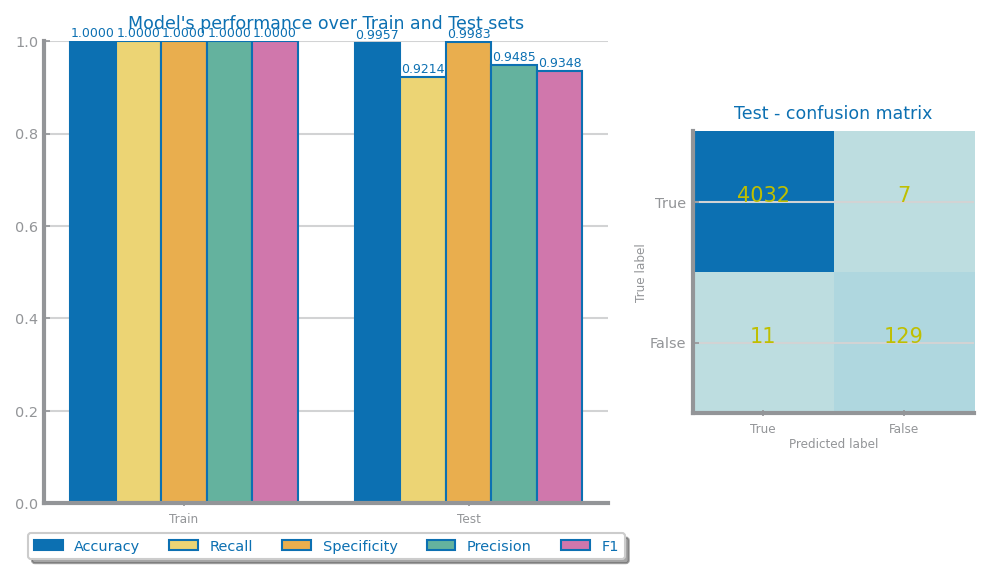

In [103]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
iterations = train_config['iterations']
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['manhattan', 'euclidean', 'chebyshev'],
}

model = KNeighborsClassifier(n_jobs=-1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)

knn_train_predictions = []
knn_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1], n_jobs = -1)
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_knn.fit(trnX, trnY)
    times['KNN']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_knn.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_knn.predict(tstX)
    times['KNN']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    knn_train_predictions.append(prd_trn)
    knn_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'KNN')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}knn.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.05471199999919918
train_predict time: 0.0014354999984789174
zpredict: 0.00042919999941659626
1 zfit time: 0.05336610000085784
train_predict time: 0.0013585999986389652
zpredict: 0.0004405999989103293
2 zfit time: 0.05354260000058275
train_predict time: 0.0013349999990168726
zpredict: 0.0006449000011343742
3 zfit time: 0.0620493999995233
train_predict time: 0.0017184000007546274
zpredict: 0.0006874999999126885
4 zfit time: 0.056242099999508355
train_predict time: 0.001662800001213327
zpredict: 0.0005220999992161524
5 zfit time: 0.05739080000057584
train_predict time: 0.0014281000003393274
zpredict: 0.0005151000004843809
6 zfit time: 0.061366699999780394
train_predict time: 0.0014471000013145385
zpredict: 0.0004530000005615875
7 zfit time: 0.053086699999767006
train_predict time: 0.0013300000009621726
zpredict: 0.00044809999963035807
8 zfit time: 0.06128749999879801
train_predict time: 0.0016620999995211605
zpredict: 0.0005244000003585825
9 zfit time: 0.06113860000004934
t

<Figure size 600x450 with 0 Axes>

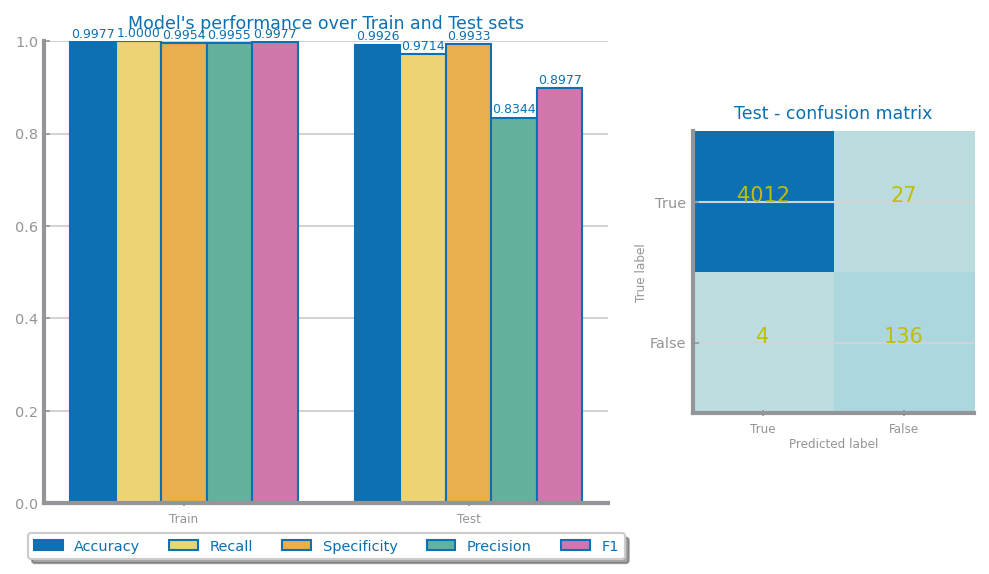

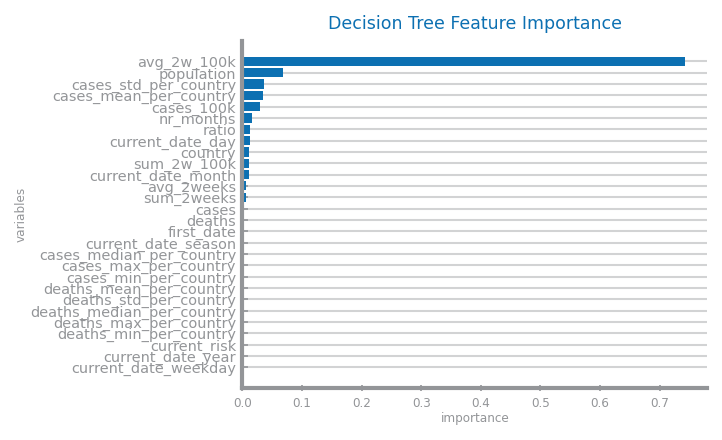

In [104]:
#  DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree
iterations = train_config['iterations']
params = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.025, 0.01, 0.005, 0.0025, 0.001],
    'max_depth': [2, 5, 10, 15, 20, 25],
}

model = DecisionTreeClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)

dt_train_predictions = []
dt_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_dt = DecisionTreeClassifier(criterion=best[0],min_impurity_decrease=best[1],max_depth=best[2],random_state=0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_dt.fit(trnX, trnY)
    times['DT']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_dt.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_dt.predict(tstX)
    times['DT']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    dt_train_predictions.append(prd_trn)
    dt_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'DT')

    # plot_tree(clf_dt, feature_names=data.columns, class_names=['0','1'])
    # plt.savefig(f'{image_dir}dt/fold_{counter}_best_tree.png', dpi=300, bbox_inches='tight')

    variables = train.columns
    importances = clf_dt.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_dt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}DT.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['DT'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Decision Tree Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}dt_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.04120630000033998
train_predict time: 0.01712539999971341
zpredict: 0.015495499999815365
1 zfit time: 0.042054599998664344
train_predict time: 0.01726579999922251
zpredict: 0.017857099999673665
2 zfit time: 0.041142300000501564
train_predict time: 0.016991199998301454
zpredict: 0.017587999998795567
3 zfit time: 0.041497899999740184
train_predict time: 0.021708999998736545
zpredict: 0.015374000000520027
4 zfit time: 0.04039750000083586
train_predict time: 0.01857419999942067
zpredict: 0.01647130000128527
5 zfit time: 0.04434670000046026
train_predict time: 0.017002999999021995
zpredict: 0.016671800000040093
6 zfit time: 0.042330000000220025
train_predict time: 0.017433600000003935
zpredict: 0.016614099999060272
7 zfit time: 0.04403739999906975
train_predict time: 0.01696760000049835
zpredict: 0.017155400000774534
8 zfit time: 0.046849799999108654
train_predict time: 0.02503890000116371
zpredict: 0.018889400000261958
9 zfit time: 0.043096699999296106
train_predict time: 0.

<Figure size 600x450 with 0 Axes>

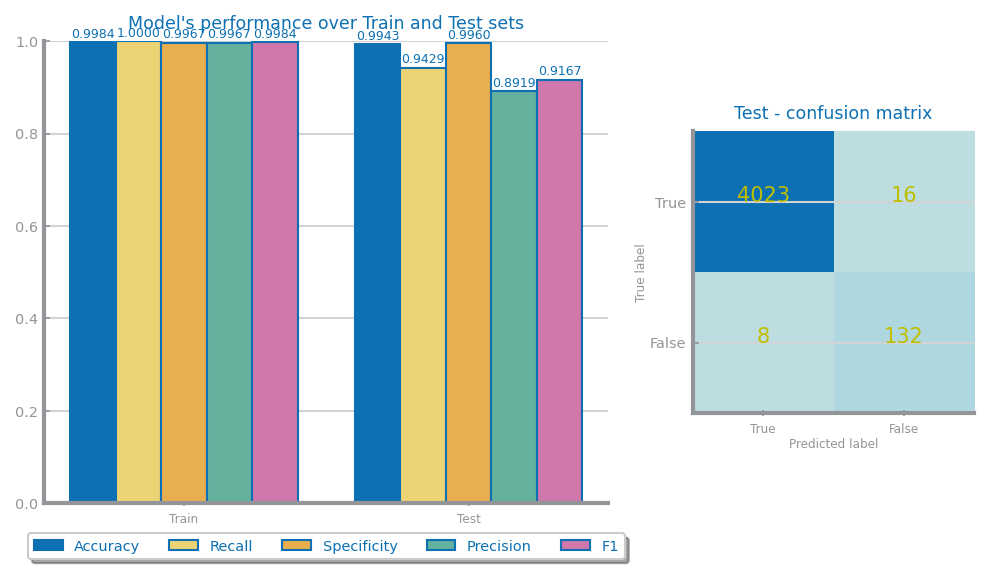

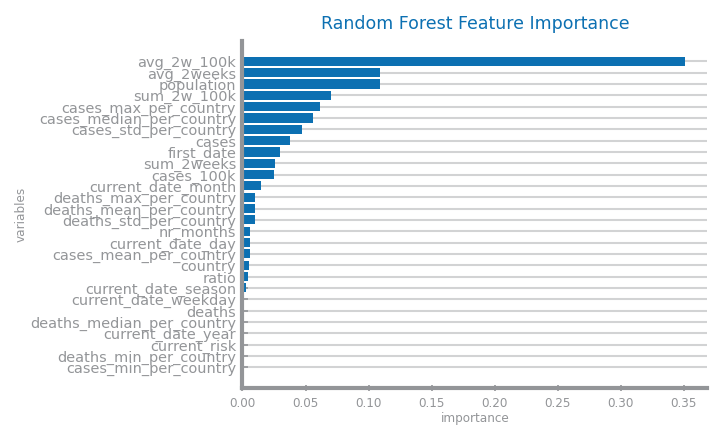

In [105]:
#  RANDOM FOREST

iterations = train_config['iterations']
params = {
    'max_depth' : [5,10,15],
    'max_features' : [.1, .3, .5, .7, .9, 1.0],
    'n_estimators' : [5, 10, 25, 50, 75, 100, 150],
}

model = RandomForestClassifier(random_state = 0, n_jobs = -1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)

rf_train_predictions = []
rf_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_rf = RandomForestClassifier(max_depth=best[0],max_features=best[1],n_estimators=best[2],random_state=0, n_jobs=-1)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_rf.fit(trnX, trnY)
    times['RF']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_rf.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_rf.predict(tstX)
    times['RF']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    rf_train_predictions.append(prd_trn)
    rf_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'RF')

    variables = train.columns
    importances = clf_rf.feature_importances_
    importance_list.append(importances)
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], std[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}rf/seed_{counter}_rf_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}rf.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['RF'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Random Forest Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}RF_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.4906238999992638
train_predict time: 0.010451000000102795
zpredict: 0.0023682999999437016
1 zfit time: 0.4728852000007464
train_predict time: 0.004311700000471319
zpredict: 0.0015272000000550179
2 zfit time: 0.34633059999941906
train_predict time: 0.0033689000010781456
zpredict: 0.000996599999780301
3 zfit time: 0.322985200000403
train_predict time: 0.0033063999999285443
zpredict: 0.001009199999316479
4 zfit time: 0.31730849999985367
train_predict time: 0.0032167999997909646
zpredict: 0.001048399999490357
5 zfit time: 0.31657739999900514
train_predict time: 0.003388400000403635
zpredict: 0.0010505000009288779
6 zfit time: 0.31396700000004785
train_predict time: 0.0032214000002568355
zpredict: 0.0009921999990183394
7 zfit time: 0.3866723000010097
train_predict time: 0.003639499998826068
zpredict: 0.0011220000014873222
8 zfit time: 0.3909278999999515
train_predict time: 0.003307900000436348
zpredict: 0.0011204000002180692
9 zfit time: 0.34191420000024664
train_predict time

<Figure size 600x450 with 0 Axes>

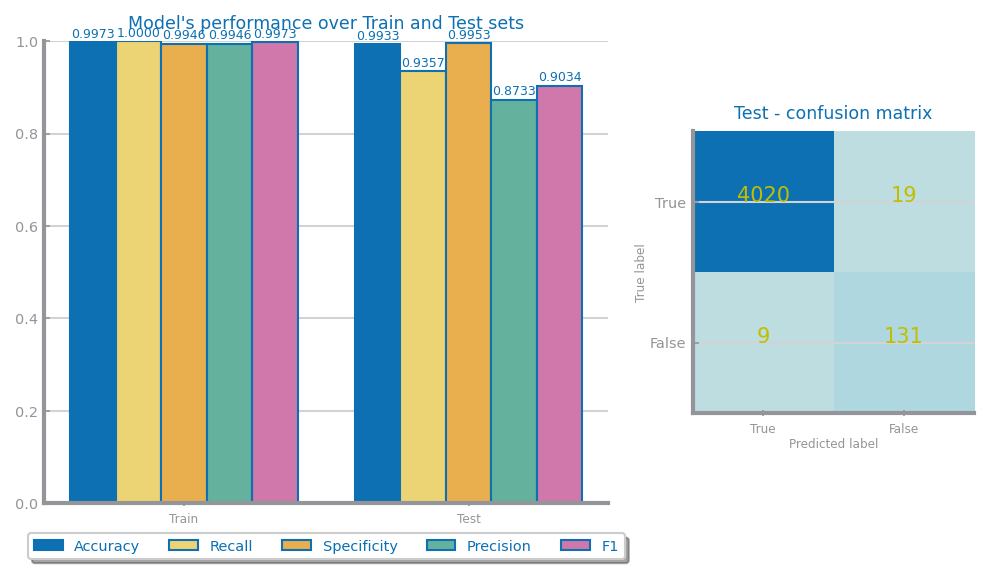

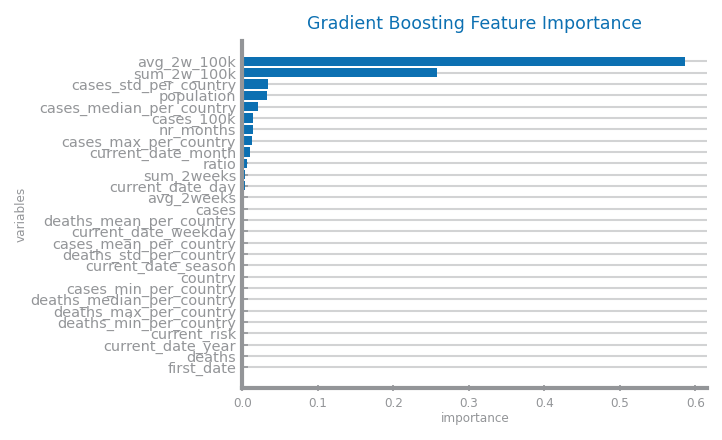

In [106]:
#  Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

iterations = train_config['iterations']

params = {
    'n_estimators' : [5, 10, 25, 50, 75, 100, 200],
    'max_depth' : [5, 10, 25],
    'learning_rate' : [.1, .5, .9]
}

model = GradientBoostingClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)

gb_train_predictions = []
gb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_gb = GradientBoostingClassifier(n_estimators=best[0], max_depth=best[1], learning_rate=best[2], random_state = 0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_gb.fit(trnX, trnY)
    times['GB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_gb.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_gb.predict(tstX)
    times['GB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    gb_train_predictions.append(prd_trn)
    gb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'GB')

    variables = train.columns
    importances = clf_gb.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_gb.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], np.std(importance_list),title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}gb/seed_{counter}_gb_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}gb.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]
fig = plt.figure()

model_importances['GB'] = list(zip(elems,mean_importance[indices]))

ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Gradient Boosting Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}GB_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

In [107]:
scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}
for i,v in model_scores.items():
    for m,v2 in v.items():
        mean = np.mean(v2)
        scores[i][m] = mean
print(scores)

{'NB': {'precision': 0.22823529411764704, 'recall': 0.6928571428571428, 'accuracy': 0.9112227805695141, 'auc': 0.8058244615003713, 'F1': 0.3433628318584071}, 'KNN': {'precision': 0.948529411764706, 'recall': 0.9214285714285714, 'accuracy': 0.9956927494615936, 'auc': 0.959847734587769, 'F1': 0.934782608695652}, 'DT': {'precision': 0.8343558282208589, 'recall': 0.9714285714285713, 'accuracy': 0.992581957406078, 'auc': 0.9823718742262937, 'F1': 0.8976897689768977}, 'RF': {'precision': 0.8918918918918918, 'recall': 0.9428571428571428, 'accuracy': 0.994256999282125, 'auc': 0.969447883139391, 'F1': 0.9166666666666666}, 'GB': {'precision': 0.8733333333333333, 'recall': 0.9357142857142856, 'accuracy': 0.9932998324958126, 'auc': 0.965505075513741, 'F1': 0.9034482758620689}}


In [108]:
scores_n = {'precision' : [], 'recall' : [], 'accuracy' : [], 'auc' : [], 'F1' : []}

for k,v in scores.items():
    print(k,v)
    scores_n['precision'].append(v['precision'])
    scores_n['recall'].append(v['recall'])
    scores_n['accuracy'].append(v['accuracy'])
    scores_n['auc'].append(v['auc'])
    scores_n['F1'].append(v['F1'])

for v in scores_n.values():
    for i in v:
        print(i)

print()

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation != 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print() 

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation == 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print()

print(model_importances)

NB {'precision': 0.22823529411764704, 'recall': 0.6928571428571428, 'accuracy': 0.9112227805695141, 'auc': 0.8058244615003713, 'F1': 0.3433628318584071}
KNN {'precision': 0.948529411764706, 'recall': 0.9214285714285714, 'accuracy': 0.9956927494615936, 'auc': 0.959847734587769, 'F1': 0.934782608695652}
DT {'precision': 0.8343558282208589, 'recall': 0.9714285714285713, 'accuracy': 0.992581957406078, 'auc': 0.9823718742262937, 'F1': 0.8976897689768977}
RF {'precision': 0.8918918918918918, 'recall': 0.9428571428571428, 'accuracy': 0.994256999282125, 'auc': 0.969447883139391, 'F1': 0.9166666666666666}
GB {'precision': 0.8733333333333333, 'recall': 0.9357142857142856, 'accuracy': 0.9932998324958126, 'auc': 0.965505075513741, 'F1': 0.9034482758620689}
0.22823529411764704
0.948529411764706
0.8343558282208589
0.8918918918918918
0.8733333333333333
0.6928571428571428
0.9214285714285714
0.9714285714285713
0.9428571428571428
0.9357142857142856
0.9112227805695141
0.9956927494615936
0.992581957406078

In [193]:
# a = pd.DataFrame(model_scores).reset_index()
# b = pd.melt(a, id_vars="index", var_name="model", value_name="score")
# c = b.explode('score')

# darkblue = '#0C70B2'


# plt.figure(figsize=(7.5,3))
# ax = sns.barplot(x='index', y='score', hue='model', data=c, ci = 'sd', errwidth=1, edgecolor = darkblue)
# ax.set_title('Baseline Model Scores')
# for i in range(len(ax.containers)):
#     ax.bar_label(ax.containers[i], fmt = '%1.4f', fontsize = 6)
# ax.legend(fontsize='x-small', title_fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# # plt.savefig(f'{image_dir}/{suffix}_scores.png', dpi=300, bbox_inches = 'tight')
